In [1]:
from pygraphblas import *
from pygraphblas import lib
from itertools import repeat
from time import time
import random
from numba import njit
from pygraphblas.gviz import draw

options_set(nthreads=1)

In [2]:
from collections import defaultdict
from itertools import groupby
from operator import itemgetter

def group_labels(T):
    d = defaultdict(list)
    for k,v in groupby(T, itemgetter(1)):
        d[k].append(list(v)[0][0])
    return d

def compare_groups(left, right):
    left = {k: set(v) for k, v in left.items()}
    right = {k: set(v) for k, v in right.items()}
    return sorted(left.values()) == sorted(right.values())

def get_louvain_cluster_assignments(cluster_matrix):
    clusters = Vector.sparse(UINT64, cluster_matrix.nrows)
    index_of_vec = Vector.sparse(UINT64, cluster_matrix.ncols)
    for i in range(cluster_matrix.nrows):
        index_of_vec[i] = i
    cluster_matrix.mxv(index_of_vec, out=clusters, semiring=UINT64.MAX_SECOND)
    return clusters

In [3]:
M = Matrix.from_lists(
    [0, 0, 0, 0,
    1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4, 4, 4,
    5, 5, 5, 5, 5,
    6, 6, 6,
    7, 7, 7, 7],
    [0, 2, 3, 6,
    1, 2, 3, 7,
    0, 2, 4, 6,
    0, 1, 3, 5,
    0, 2, 4, 6,
    1, 3, 5, 6, 7,
    0, 4, 6,
    1, 3, 5, 7],
    list(repeat(1.0, 32)),
    typ=FP64,
)

@njit
def seed_rng(seed):
    random.seed(seed)

@unary_op(FP64)  
def random_scaler(x): 
    return random.uniform(0.0001, x)

In [18]:
def louvain_cluster(graph, max_iters=20, seed=None):
    if seed:
        seed_rng(seed)
    assert graph.square, 'First input matrix must be square.'
    start = time()
    rows = graph.nrows
    ApAT = graph.transpose(accum=FP64.PLUS)
    k = graph.reduce_vector()
    m = k.reduce_int() / 2.0
    nkm = (-k) / m
    S = Matrix.identity(BOOL, rows)
    S_row = Vector.sparse(BOOL, rows)
    empty = Vector.sparse(BOOL, rows)   
    v = Vector.sparse(FP64, rows)
    vertices_changed = True
    iters = 0
    
    while vertices_changed and iters < max_iters:
        vertices_changed = False
        for i, _ in k:
            S.extract_col(i, out=S_row)
            S.assign_row(i, empty)
            ApAT.extract_row(i, out=v)
            w = k.dup()
            w.assign_scalar(nkm[i], accum=FP64.TIMES, mask=k, desc=descriptor.S)
            v += w
            q = v @ S
            kappa = q.reduce_float(FP64.MAX_MONOID)
            t = q.select('==', kappa)
            while len(t) != 1:
                p = t.apply(random_scaler)
                max_p = p.reduce_float(FP64.MAX_MONOID)
                t = p.select('==', max_p)
            S.assign_row(i, t)
            if not t.iseq(S_row):
                vertices_changed = True
        iters += 1
    print('Input size ', len(graph), ' took ', time() - start)
    return S

Input size  24  took  0.0385441780090332


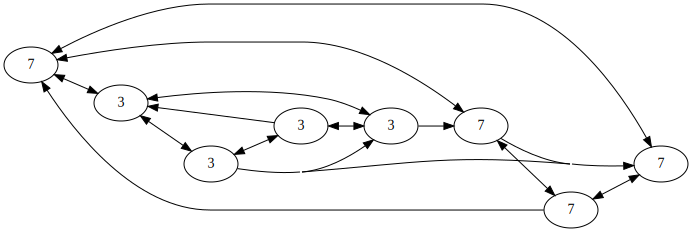

In [17]:
ans = louvain_cluster(M.offdiag(), 10)
labels = get_louvain_cluster_assignments(ans)
draw(M.offdiag(), show_weight=False, label_vector=labels)

In [22]:
sizes = [(6, 50), (4, 100), (3, 500), (3, 1000), (3, 5000)]
#sizes = [(3, 5000)]

for iters, size in sizes:
    data = Matrix.from_tsv('louvain_data/simulated_blockmodel_graph_%s_nodes.tsv' % size, FP64, size, size)
    print('Loaded', size, 'nodes.')
    data.sparsity = lib.GxB_BITMAP
    ans = louvain_cluster(data, max_iters=iters, seed=42)
    assignments = get_louvain_cluster_assignments(ans)
    with open('louvain_data/simulated_blockmodel_graph_%s_nodes_truePartition.tsv' % size) as truth:
        T = Vector.sparse(UINT8, size)
        for line in truth:
            i, j = map(int, line.split('\t'))
            T[i-1] = j
    print(size, 'Correct?', compare_groups(group_labels(assignments), group_labels(T)))
    

Loaded 50 nodes.
Input size  319  took  0.07941722869873047
50 Correct? False
Loaded 100 nodes.
Input size  778  took  0.07402563095092773
100 Correct? False
Loaded 500 nodes.
Input size  9384  took  0.3471841812133789
500 Correct? False
Loaded 1000 nodes.
Input size  20135  took  0.8749489784240723
1000 Correct? False
Loaded 5000 nodes.
Input size  101973  took  11.2220778465271
5000 Correct? False


In [7]:
import community
import networkx as nx
from time import time

name = lambda v: "louvain_data/simulated_blockmodel_graph_{}_nodes".format(v)

def make_dict(tup):
    trued = {}
    for n,c in tup:
        trued.setdefault(c, []).append(n)
    trued = { tuple(trued[c]):c for c in trued }
    return trued

In [8]:
def get_nodes_comm(name):
    with open(name + "_truePartition.tsv", "r") as f:
        truep = [tuple(map(int, l.split('\t'))) for l in f]

    G = nx.read_edgelist(name + ".tsv", delimiter='\t', data=(('weight', float),), create_using=nx.DiGraph())
    start = time()
    partition = community.best_partition(G.to_undirected())
    print(name, 'took', time() - start)
    pl = [ (int(n), c) for n,c in list(partition.items()) ]
    pl.sort()
    return make_dict(truep), make_dict(pl)

In [9]:
for numv in [50, 100, 500, 1000, 5000]:
    trued, pd = get_nodes_comm(name(numv))

louvain_data/simulated_blockmodel_graph_50_nodes took 0.008720874786376953
louvain_data/simulated_blockmodel_graph_100_nodes took 0.01568007469177246
louvain_data/simulated_blockmodel_graph_500_nodes took 0.187363862991333
louvain_data/simulated_blockmodel_graph_1000_nodes took 0.26988649368286133
louvain_data/simulated_blockmodel_graph_5000_nodes took 2.8232150077819824
